In [66]:
%load_ext autoreload
%autoreload 2

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pyesg 
import  evaluation as eval
import preproccessing as prep 

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [4]:
acwi_prices = pd.read_excel('msci_acwi_net_30.10.23.xlsx')
acwi_prices.index = pd.DatetimeIndex(acwi_prices['Date'])
acwi_prices = acwi_prices['ACWI Standard Net (Large+Mid Cap)']

<AxesSubplot:xlabel='Date'>

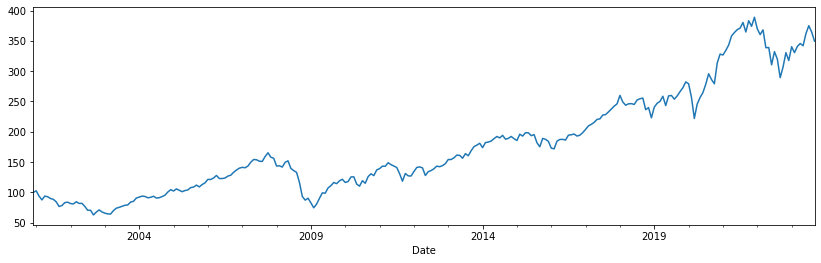

In [5]:
acwi_prices.plot(figsize=(14,4))

In [76]:
acwi_returns = prep.log_returns(acwi_prices)

periods = [('2001-01-31', '2023-09-30'),
           ('2001-01-31', '2019-12-31'), 
           ('2000-08-31', '2023-07-31'),
           ('2003-03-31', '2020-03-31'),
           ('2003-03-31', '2022-12-31'),
           ('2009-02-28', '2022-12-31'),
           ('2007-10-31', '2022-12-31'),
           ('2007-10-31', '2015-05-30')
           ]

summary = []

for period in periods:
    summary.append(prep.assets_performance(acwi_returns[period[0]:period[1]]))

df = pd.DataFrame(data=summary, index=periods)
df.head(10)

,annualised_mean,annualised_sigma,skew,kurtosis,sharp_ratio,max_drawdown
"(2001-01-31, 2023-09-30)",0.055009,0.160995,-0.856140,2.121958,0.538119,-0.549231
"(2001-01-31, 2019-12-31)",0.054624,0.154934,-0.987229,2.835527,0.550549,-0.549231
"(2000-08-31, 2023-07-31)",0.058540,0.161136,-0.874261,2.159978,0.613556,-0.549231
"(2003-03-31, 2020-03-31)",0.072407,0.154143,-1.182134,3.763084,0.953037,-0.549231
"(2003-03-31, 2022-12-31)",0.080425,0.157982,-0.983730,2.908463,1.105673,-0.549231
"(2009-02-28, 2022-12-31)",0.104803,0.154169,-0.435559,0.801444,1.680774,-0.256253
"(2007-10-31, 2022-12-31)",0.045327,0.172403,-0.860163,2.140233,0.307968,-0.549231
"(2007-10-31, 2015-05-30)",0.028687,0.187189,-1.004988,2.562275,-0.024306,-0.549231


<AxesSubplot:xlabel='ACWI Standard Net (Large+Mid Cap)', ylabel='Count'>

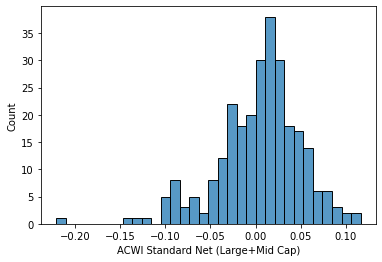

In [82]:
sns.histplot(data=acwi_returns, bins=32)

In [7]:
gbm_std = 0.155
gbm_mean = 0.5*gbm_std**2 + 0.072
gbm_mean

0.08401249999999999

In [206]:

model = pyesg.GeometricBrownianMotion(mu=0.072,sigma=0.155)
scenarios = model.scenarios(349.54,1,100,50)

In [18]:
np.savetxt('acwi_scenarios.csv', scenarios, delimiter=', ', fmt='%1.2f')

In [207]:
perc = np.percentile(scenarios,[1,5,25,50,75,95,99],axis=0)
#fanchart(None, perc)

def percentile_summary(perc):
    perc_dict = {'perc': ['1','5','25','50','75','95','99'],
                 '1': perc[:,1],
                 '2': perc[:,2],
                 '3': perc[:,3],
                 '5': perc[:,5],
                 '10': perc[:,10],
                 '15': perc[:,15],
                 '20': perc[:,20],
                 '50': perc[:,50]
                 }
    
    perc_summary = pd.DataFrame(perc_dict)
    perc_summary.set_index('perc', inplace=True)
    return perc_summary
percentile_summary(perc)

,1,2,3,5,10,15,20,50
perc,,,,,,,,
1,262.917586,249.542564,234.076704,268.798483,234.797882,315.123182,271.963597,733.526781
5,290.574525,272.328130,275.684894,292.089709,279.983237,355.221288,429.274151,995.958810
25,326.672533,329.108326,333.705510,378.013828,449.015992,578.973296,709.890618,2692.587825
50,359.885972,380.876623,412.425487,479.652120,593.601027,831.600990,1154.723668,6485.240127
75,395.536887,440.140296,503.784758,584.536693,899.774209,1165.455332,1709.685236,16090.393953
95,472.906583,554.840130,635.757811,744.547970,1299.645079,2091.111098,3739.837977,45448.563478
99,480.455940,598.253910,747.702801,1085.490170,1821.747257,2864.857456,4335.960881,75018.533877


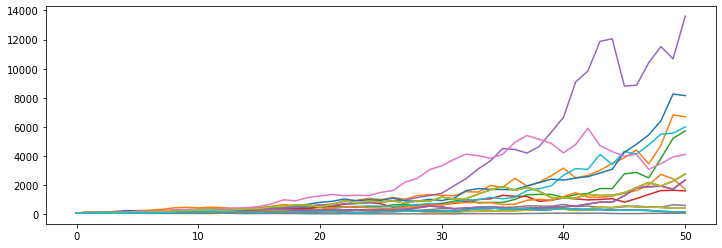

In [109]:
ax,fig = plt.subplots(figsize=(12,4))
for i in np.random.randint(0,100,20):
    sns.lineplot(data=scenarios[i])

In [111]:
scenarios_df = pd.DataFrame(data=scenarios.T, index=range(0,51), columns=range(0,100))
scenarios_returns = prep.log_returns(scenarios_df)
display(eval.describe_scenarios_vertically(scenarios_returns))


,annualised_mean,annualised_sigma,skew,kurtosis,sharp_ratio,max_drawdown
count,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000
mean,0.702640,0.532684,-0.039377,-0.034644,4.415460,-0.390144
std,0.252926,0.049660,0.306567,0.520855,1.733812,0.126432
min,-0.049208,0.387236,-0.932019,-0.994296,-0.501358,-0.791581
25%,0.563179,0.496797,-0.228305,-0.388793,3.412028,-0.453207
50%,0.709127,0.534095,-0.041418,-0.103634,4.399301,-0.364290
75%,0.861323,0.566998,0.181801,0.243073,5.623400,-0.294000
max,1.253192,0.669246,0.613324,1.355035,9.100973,-0.166208


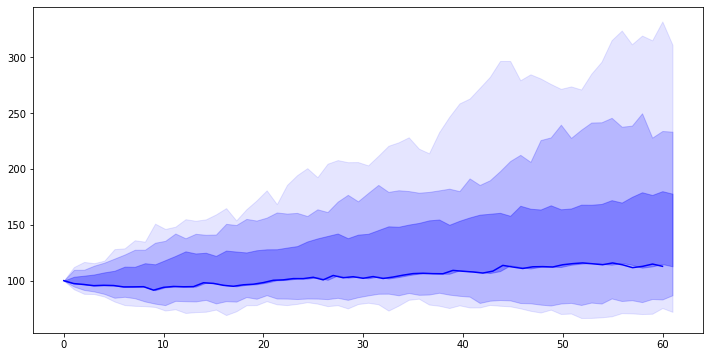

In [26]:
fanchart(scenarios_returns,perc)

In [112]:
scenarios_returns.shape

(50, 100)

In [245]:
def fanchart(hist,scenarios):
    percentiles = np.percentile(scenarios,[1,5,25,50,75,95,99],axis=1)
    hist_len = hist.shape[0]
    n_steps = scenarios.shape[1]
    x1 = np.arange(-hist_len+1,1)
    x2 = np.linspace(0,n_steps)
    
    fig,ax = plt.subplots(figsize=(12,6))
    ax.plot(x1, hist,color='red')
    ax.plot(x2, percentiles[3], color='blue')
      
    for i in range(1,4):
        ax.fill_between(x=x2,y1=percentiles[i-1],y2=percentiles[-i], color='blue', alpha=i/10)
       

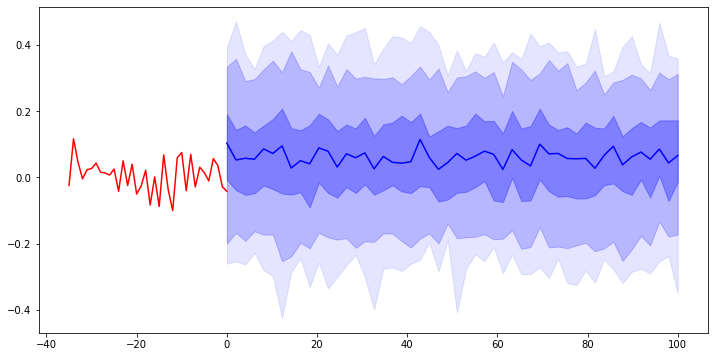

In [246]:
fanchart(acwi_returns.iloc[-36:],scenarios_returns)

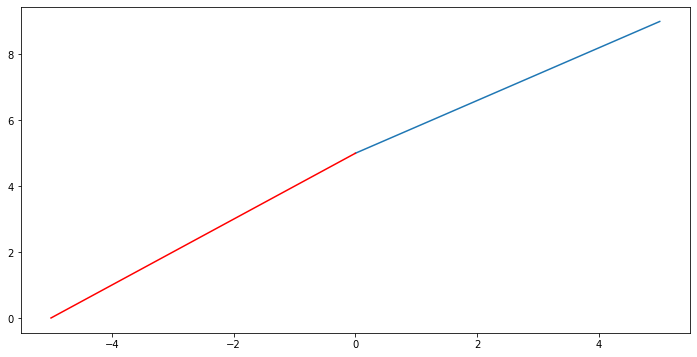

In [166]:
x = np.linspace(0,5,5)
y= np.arange(5,10)
fig,ax = plt.subplots(figsize=(12,6))
ax.plot(x,y)
x1 = np.linspace(-5,0,6)
y1 = np.arange(0,6) 
ax.plot(x1,y1,color='red')

In [22]:
below_zero = np.round(np.count_nonzero(scenarios<100,axis=0)/600,2)

In [242]:
from scipy.stats import invgamma
T = acwi_returns.shape[0]
mu = acwi_returns.mean()
sum_res = ((acwi_returns - mu).sum()**2)*0.5
mean = (T/2+1)
a = sum_res/mean-1
s = invgamma.rvs(a, loc=mean,scale=sum_res,size=100)**0.5


ValueError: Domain error in arguments.